In [20]:
from redbaron import redbaron
redbaron.ipython_behavior = False

import numpy as np
import scipy
import pandas as pd
from pyha.common.util import plot_freqz
from pyha import Sfix, simulate, hardware_sims_equal, sims_close
import os

# this ignores some 'log' warnings that would fail the unit tests as they include system path
import warnings
warnings.filterwarnings('ignore')


import matplotlib
# set 'interactive' to False and run 'Restart & Run all' before you commit this notebook, else you will get failed tests in CI.
# also consider running in virtualenv, tests may fail if, for example, matplotlib versions differ
interactive = False
if interactive:
    matplotlib.use('nbagg')
    from pylab import rcParams
    rcParams['figure.figsize'] = 8, 4
    %load_ext autoreload
    %autoreload 2
    
import matplotlib.pyplot as plt

# in Travis CI we cannot run GATE simulations
os.environ["PYHA_SKIP_GATE"] = '1'


# Design filter

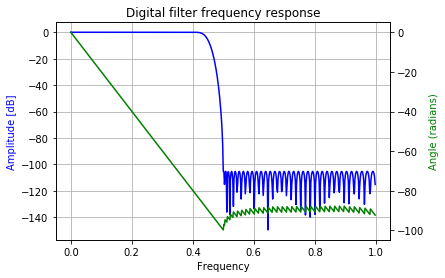

In [2]:
taps = signal.remez(128, [0, 0.2, 0.25, 0.5], [1, 0])
plot_freqz(taps)

# Diagram

![alt text](diagram.png "Title")

# Pyha model

In [3]:
from pyhacores.filter import FIR
from pyha import Hardware

class BasebandFilter(Hardware):
    def __init__(self, taps):
        # registers
        self.fir = [FIR(taps), FIR(taps)]
        
        # constants (written in CAPS)
        self.TAPS = taps
        self.DELAY = self.fir[0].DELAY
    
    def main(self, x):
        """ Apply FIR filter to 'real' and 'imag' channels """
        out = x
        out.real = self.fir[0].main(x.real)
        out.imag = self.fir[1].main(x.imag)
        return out

    def model_main(self, x):
        """ Golden output """
        return scipy.signal.lfilter(self.TAPS, [1.0], x)


# Evaluate frequency and phase response

In [22]:
# get impulse response of the filter
inp = [0.0 + 0.0j] * 512
inp[0] = 1.0 + 1.0j

In [31]:
dut = BasebandFilter(taps)
sims = simulate(dut, # pyha model
                inp, # input to the 'main' function
                simulations=['MODEL', 'PYHA', 'RTL', 'GATE']
               )

INFO:simulation:Running MODEL simulation!
INFO:simulation:Running PYHA simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running RTL simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running COCOTB & GHDL simulation....
INFO:simulation:Simulations completed!


In [6]:
pd.DataFrame(sims)

,MODEL,PYHA,RTL
0,(5.98723154595e-06+5.98723154595e-06j),0j,0j
1,(3.94653493842e-06+3.94653493842e-06j),0j,0j
2,(-1.16914696356e-05-1.16914696356e-05j),(-1.52587890625e-05-1.52587890625e-05j),(-1.52587890625e-05-1.52587890625e-05j)
3,(-1.11244987e-05-1.11244987e-05j),(-7.62939453125e-06-7.62939453125e-06j),(-7.62939453125e-06-7.62939453125e-06j)
4,(1.60088696452e-05+1.60088696452e-05j),(7.62939453125e-06+7.62939453125e-06j),(7.62939453125e-06+7.62939453125e-06j)
5,(2.85895584662e-05+2.85895584662e-05j),(2.28881835938e-05+2.28881835938e-05j),(2.28881835938e-05+2.28881835938e-05j)
6,(-1.75175220734e-05-1.75175220734e-05j),(-1.52587890625e-05-1.52587890625e-05j),(-1.52587890625e-05-1.52587890625e-05j)
7,(-5.46997038127e-05-5.46997038127e-05j),(-5.34057617188e-05-5.34057617188e-05j),(-5.34057617188e-05-5.34057617188e-05j)
8,(6.18856752713e-06+6.18856752713e-06j),0j,0j
9,(9.08709788767e-05+9.08709788767e-05j),(8.39233398438e-05+8.39233398438e-05j),(8.39233398438e-05+8.39233398438e-05j)


In [7]:
assert hardware_sims_equal(sims)

INFO:simulation:sims_close(rtol=1e-16, atol=1e-16)
INFO:simulation:Using "PYHA" as golden output
INFO:simulation:PYHA OK!
INFO:simulation:RTL OK!


In [35]:
assert sims_close(sims)

INFO:simulation:sims_close(rtol=0.0001, atol=3.0517578125e-05)
INFO:simulation:Using "MODEL" as golden output
INFO:simulation:MODEL OK!
INFO:simulation:PYHA OK!
INFO:simulation:RTL OK!


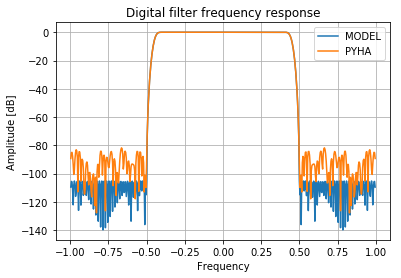

In [36]:
gain_fix = 512-128-22 # this is not 100% precise
plt.title('Digital filter frequency response')
plt.magnitude_spectrum(np.array(sims['MODEL']) * gain_fix, window=matplotlib.mlab.window_none, scale='dB', label='MODEL')
plt.magnitude_spectrum(np.array(sims['PYHA']) * gain_fix, window=matplotlib.mlab.window_none, scale='dB', label='PYHA')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.grid()
plt.legend()
plt.show()

In [23]:
dut = BasebandFilter(taps)
with Sfix._float_mode:
    sims = simulate(dut, inp, simulations=['MODEL', 'PYHA'])

INFO:simulation:Running MODEL simulation!
INFO:simulation:Running PYHA simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Simulations completed!


# Sine response

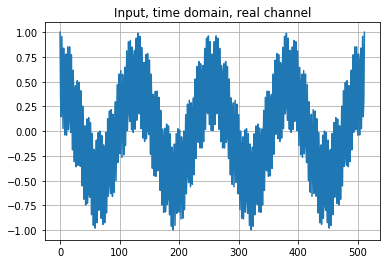

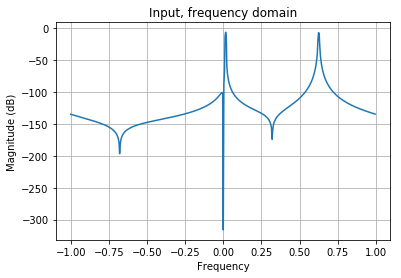

In [11]:
fs = 256
t = np.linspace(0, 2, 2*fs)
s0 = np.exp(2 * np.pi * 2 * t * 1j) * 0.5
s1 = np.exp(2 * np.pi * 80 * t * 1j) * 0.5
inp = s0 + s1

plt.title('Input, time domain, real channel')
plt.plot(inp.real)
plt.grid()
plt.show()

plt.title('Input, frequency domain')
plt.magnitude_spectrum(inp, scale='dB')
plt.grid()
plt.show()

In [12]:
dut = BasebandFilter(taps)
sims = simulate(dut, inp) # run all simulations
assert hardware_sims_equal(sims)

INFO:simulation:Running MODEL simulation!
INFO:simulation:Running PYHA simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running RTL simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running COCOTB & GHDL simulation....
INFO:simulation:Simulations completed!
INFO:simulation:sims_close(rtol=1e-16, atol=1e-16)
INFO:simulation:Using "PYHA" as golden output
INFO:simulation:PYHA OK!
INFO:simulation:RTL OK!


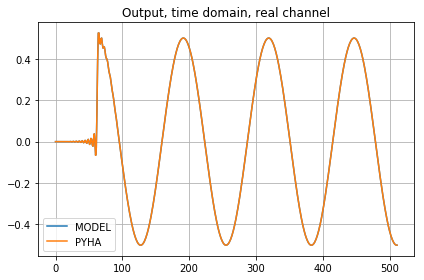

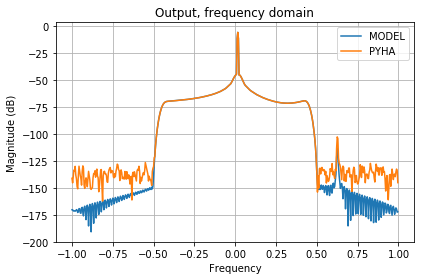

In [13]:
plt.title('Output, time domain, real channel')
plt.plot(np.array(sims['MODEL']).real, label='MODEL')
plt.plot(np.array(sims['PYHA']).real, label='PYHA')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.title('Output, frequency domain')
plt.magnitude_spectrum(sims['MODEL'], scale='dB', label='MODEL')
plt.magnitude_spectrum(sims['PYHA'], scale='dB', label='PYHA')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Noise response

In [17]:
np.random.seed(0)  # reproduce tests
inp = np.random.uniform(-1, 1, 512) + np.random.uniform(-1, 1, 512)*1j
# inp *= 0.75

dut = BasebandFilter(taps)
sims = simulate(dut, inp) # run all simulations
assert hardware_sims_equal(sims)

INFO:simulation:Running MODEL simulation!
INFO:simulation:Running PYHA simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running RTL simulation!
INFO:simulation:Converting complex inputs to ComplexSfix(left=0, right=-17)
INFO:simulation:Running COCOTB & GHDL simulation....
INFO:simulation:Simulations completed!
INFO:simulation:sims_close(rtol=1e-16, atol=1e-16)
INFO:simulation:Using "PYHA" as golden output
INFO:simulation:PYHA OK!
INFO:simulation:RTL OK!


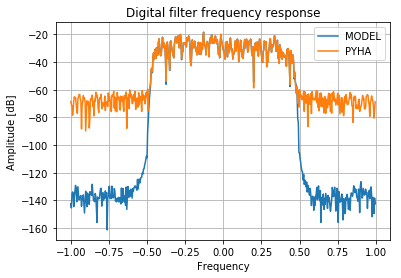

In [18]:
plt.title('Digital filter frequency response')
# plt.magnitude_spectrum(inp, scale='dB', label='MODEL')
plt.magnitude_spectrum(sims['MODEL'], scale='dB', label='MODEL')
plt.magnitude_spectrum(sims['PYHA'], scale='dB', label='PYHA')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
plt.legend()
plt.grid()
plt.show()

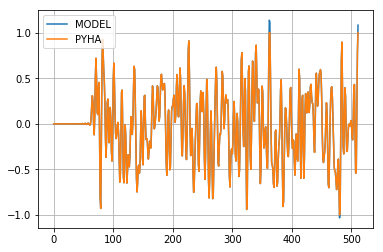

In [19]:
plt.plot(np.array(sims['MODEL']).real, label='MODEL')
plt.plot(np.array(sims['PYHA']).real, label='PYHA')
plt.grid()
plt.legend()
plt.show()